In [66]:
import random
import csv
from collections import Counter
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pylab as plt
import itertools
from math import *

In [78]:
#function to get counts of features
def naive_bayes(training, testing, features):
    
    num_features = len(features) - 1
    num_poisonous = 0
    num_edible = 0
    
#initialise arrays
#used feature names for first lines, so arrays would be string type
    edible = np.array(['class','cap-shape','cap-surface','cap-color','bruises','odor','gill-attachment',
                       'gill-spacing','gill-size','gill-color','stalk-shape','stalk-root',
                       'stalk-surface-above-ring','stalk-surface-below-ring','stalk-color-above-ring',
                       'stalk-color-below-ring','veil-type','veil-color','ring-number','ring-type',
                       'spore-print-color','population','habitat'])
    poisonous = edible
    
#split data into poisonous and edible, save into 2 arrays
#take counts of each class
    for line in training:
        if line[0] == "p":
            poisonous = np.vstack([poisonous,line])
            num_poisonous = num_poisonous + 1
        else:
            edible = np.vstack([edible,line])
            num_edible = num_edible + 1
            
#take only the features indicated by the indices in the features array
    poisonous = poisonous[:,features]
    edible = edible[:,features]
            
#edible_counts and poisonous_counts will contain Counters for each feature
#the first line is the counter for feature 1, the second line for feature 2, etc
    edible_counts = [[] for j in range(num_features)]
    poisonous_counts = [[] for j in range(num_features)]
    
#an array to store the number of different types of features encountered in the training set, for each feature
#eg feature_types[0] contains the number of different values that feature 0 can take on
    feature_types = []
    
#get Counters for each feature, split by class
    for f in range(num_features):
        edible_counts[f] = Counter((edible[range(1,num_edible),[f+1]]))     #use f+1 becase first column is class label
        poisonous_counts[f] = Counter((poisonous[range(1,num_poisonous),[f+1]]))
        feature_types.append(max(len(edible_counts[f]),len(poisonous_counts[f])))  #get number of values features can
                                                                                   #take on, use max of the classes
#    for x in range(num_features):
#        print(edible_counts[x])
#        print(poisonous_counts[x])
#    print(feature_types)
    
    y_true = []
    y_pred = []
    
    for t in testing:
        if(t[0] == "p"):
            y_true.append(1)
        else:
            y_true.append(0)
        
        y_pred.append(class_prediction(edible_counts, poisonous_counts, num_poisonous, num_edible, feature_types, features, t[1:]))
        
    cm = confusion_matrix(y_true, y_pred)

#plot confusion matrix
    title = "Confusion Matrix"
    classes = ['edible','poisonous']
    cmap=plt.cm.BuPu
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if cm.max() > 1:
        thresh = cm.max()/2
    else:
        thresh = 1
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
#find accuracy
    accuracy = (cm[0][0] + cm[1][1])/(len(testing))*100
    print("Accuracy = ", accuracy, "%")

In [75]:
#mushroom is one line of data, with the class label removed, i.e just a list of features
def class_prediction(edible_counts, poisonous_counts, num_poisonous, num_edible, feature_types, features, mushroom):
    p = 1
    e = 1
    i = 0
    new_features = [x - 1 for x in features]
    new_features = new_features[1:]
    mushroom = np.array(mushroom)
    mushroom = mushroom[new_features]
    
    for feature in mushroom:
        p = p * (poisonous_counts[i].get(feature,0) + 1)/(num_poisonous + feature_types[i])
        e = e * (edible_counts[i].get(feature,0) + 1)/(num_edible + feature_types[i])
        i = i + 1
        
    poisonous_prob = num_poisonous/(num_poisonous + num_edible)
    edible_prob = num_edible/(num_poisonous + num_edible)
    
    poisonous_pred = (p * poisonous_prob)/(p*poisonous_prob + e*edible_prob)
    edible_pred = (e * edible_prob)/(p*poisonous_prob + e*edible_prob)
    
    if poisonous_pred > edible_pred:
        return 1
    else:
        return 0

---
Reading in the data from the file, and splitting it into training and testing data:

In [79]:
with open("agaricus-lepiota.data", 'r') as file:
    data = list(csv.reader(file))

#split dataset randomly into training and testing data
training_data = random.sample(data, int(len(data)*2/3))
testing_data = []
for line in data:
    if line not in training_data:
        testing_data.append(line)

---
Running the classifier with all the features:

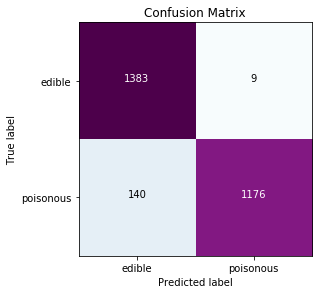

Accuracy =  94.49778434268833 %


In [80]:
features0 = np.linspace(0,22,23,dtype=int)
naive_bayes(training_data, testing_data, features0)

----
Training the classifier on six features: odor, spore-print-colour, stalk-surface-below-ring, stalk-colour-above-ring, habitat and cap-colour.

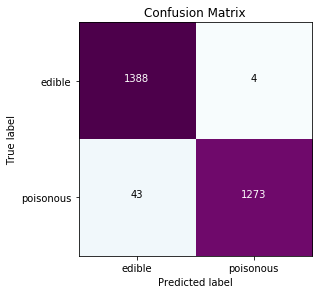

Accuracy =  98.26440177252584 %


In [81]:
features1 = [0,3,5,13,14,20,22]
naive_bayes(training_data, testing_data, features1)

----
Running the classifer on all features but odor:

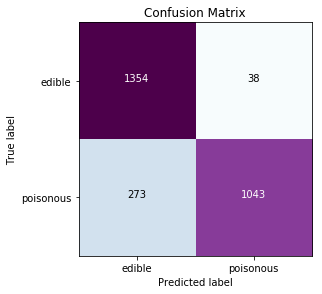

Accuracy =  88.51550960118169 %


In [82]:
features2 = [0,1,2,3,4,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]
naive_bayes(training_data, testing_data, features2)

In [89]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
le = preprocessing.LabelEncoder()

data = np.loadtxt("agaricus-lepiota.data", dtype = str, delimiter = ",")

new_data = np.zeros((len(data), len(data[0])), int)
for i in range(len(data[0])):
    new_data[:,i] = np.transpose(le.fit_transform(data[:,i]))
    
train, test = train_test_split(new_data, test_size=0.33)
    
X = train[:,1:]
y = train[:,0]

clf = MultinomialNB()
clf.fit(X, y)
p = (clf.predict(test[:,1:]))
cm = confusion_matrix(test[:,0], p)
print(cm)
print((cm[0,0]+cm[1,1])/len(test))

[[1304  107]
 [ 403  867]]
0.8097724729578516
